In [64]:
%load_ext autoreload
%autoreload 2

import sys

module_dir = '../'
print(sys.path)

if module_dir not in sys.path:
    sys.path.append(module_dir)

print(sys.path)

import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
from models import *
import test_systems_1d as systems_1d
import itertools
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import NoNorm
from matplotlib.colors import Normalize
from tqdm import tqdm
import gpjax as gpx
from sklearn.decomposition import PCA
import scipy.io
from scipy.interpolate import griddata
from dataloaders import *
from sklearn.metrics import r2_score 
from mpl_toolkits.axes_grid1 import make_axes_locatable

from jax import config
config.update("jax_enable_x64", True)

plt.rcParams["lines.linewidth"] = 3
plt.rcParams["font.size"] = 14

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python310.zip', '/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10', '/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/lib-dynload', '', '/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages', '/Users/tomcowperthwaite/Documents/GitHub/pyqg_parameterization_benchmarks/src', '../']
['/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python310.zip', '/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10', '/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/lib-dynload', '', '/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages', '/Users/tomcowperthwaite/Documents/GitHub/pyqg_parameterization_benchmarks/src', '../']


In [2]:
problem = 'ns'
n_train = 312
n_test = 200
# darcy only
r = 15
# PV_param only
config = 'eddy'
resolution = 48
filter = 'sharp'
level = 'upper'
time_size = None

if problem == 'darcy':
    dataloader_params = [n_train, n_test, r]
    s = int(((421 - 1) / r) + 1)
    extent = [0, 1, 0, 1]
    x_cmap = 'coolwarm'
    y_cmap = 'viridis'
    x_norm = lambda: TwoSlopeNorm(vcenter=0)
    y_norm = lambda: "linear"
elif problem == 'ns':
    dataloader_params = [n_train, n_test]
    s = 64
    extent = [0, 2*np.pi, 0, 2*np.pi]
    x_cmap = 'coolwarm'
    y_cmap = 'coolwarm'
    x_norm = lambda: TwoSlopeNorm(vcenter=0)
    y_norm = lambda: TwoSlopeNorm(vcenter=0)
elif problem == 'helm':
    dataloader_params = [n_train, n_test]
    s = 101
    extent = [0, 1, 0, 1]
    x_cmap = 'viridis'
    y_cmap = 'coolwarm'
    x_norm = lambda: "linear"
    y_norm = lambda: TwoSlopeNorm(vcenter=0)
elif problem == 'PV_param':
    dataloader_params = [n_train, n_test, config, resolution, filter, time_size]
    s = resolution
    extent = [0, 1e6, 0, 1e6]
    x_cmap = 'coolwarm'
    y_cmap = 'coolwarm'
    x_norm = lambda: TwoSlopeNorm(vcenter=0)
    y_norm = lambda: TwoSlopeNorm(vcenter=0)

dataloader_dict = {'darcy':get_darcy_data, 'ns':get_navier_stokes_data, 'helm':get_helmholtz_data, 'PV_param': get_PV_param_data}
if problem == 'PV_param':
    x_train, y_train, x_test, y_test, x_scale, y_scale = dataloader_dict[problem](*dataloader_params)
else:
    x_train, y_train, x_test, y_test, x_grid, y_grid = dataloader_dict[problem](*dataloader_params)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(40000, 4096) (40000, 4096)
(32000, 4096) (32000, 4096)
(8000, 4096) (8000, 4096)
(312, 4096) (312, 4096) (200, 4096) (200, 4096)


In [3]:
import sys
module_dir = '../'
if module_dir not in sys.path:
    sys.path.append(module_dir)
from models import *
import gpjax as gpx

In [29]:
n, m = 20, 20

model = full_model(problem = problem, n = n, m = m, ARD = False, multiinput = True, standardise = True, combine_pca = None)
model.fit(x_train, y_train)

does x pca
does y pca


  0%|          | 0/20 [00:00<?, ?it/s]

[1.]
float64


  5%|▌         | 1/20 [00:05<01:41,  5.35s/it]

Optimization terminated successfully.
         Current function value: -569.752794
         Iterations: 60
         Function evaluations: 96
         Gradient evaluations: 96
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([46.2725091], dtype=float64), variance=Array([19.99999898], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=312, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.01589146], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 10%|█         | 2/20 [00:12<01:57,  6.53s/it]

         Current function value: -546.241699
         Iterations: 78
         Function evaluations: 170
         Gradient evaluations: 158
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([44.68195501], dtype=float64), variance=Array([20.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=312, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.01748344], dtype=float64))
[2.]
[1.]
[1.]
float64


 15%|█▌        | 3/20 [00:17<01:39,  5.84s/it]

Optimization terminated successfully.
         Current function value: -501.941026
         Iterations: 61
         Function evaluations: 99
         Gradient evaluations: 99
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([44.41970566], dtype=float64), variance=Array([19.99999387], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=312, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.0231019], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 20%|██        | 4/20 [00:26<01:49,  6.86s/it]

         Current function value: -563.843871
         Iterations: 79
         Function evaluations: 189
         Gradient evaluations: 177
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([44.76359903], dtype=float64), variance=Array([20.], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=312, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.01545819], dtype=float64))
[2.]
[1.]
[1.]
float64


 25%|██▌       | 5/20 [00:30<01:31,  6.11s/it]

Optimization terminated successfully.
         Current function value: -511.989255
         Iterations: 51
         Function evaluations: 81
         Gradient evaluations: 81
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([44.24086773], dtype=float64), variance=Array([19.99999113], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=312, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.02164948], dtype=float64))
[2.]
[1.]
[1.]
float64


 30%|███       | 6/20 [00:36<01:20,  5.78s/it]

Optimization terminated successfully.
         Current function value: -396.591894
         Iterations: 63
         Function evaluations: 92
         Gradient evaluations: 92
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([39.96385492], dtype=float64), variance=Array([19.99999991], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=312, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.03716207], dtype=float64))
[2.]
[1.]
[1.]
float64


 35%|███▌      | 7/20 [00:40<01:09,  5.37s/it]

Optimization terminated successfully.
         Current function value: -390.186981
         Iterations: 50
         Function evaluations: 85
         Gradient evaluations: 85
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([39.34993878], dtype=float64), variance=Array([19.99998749], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=312, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.03787221], dtype=float64))
[2.]
[1.]
[1.]
float64


 40%|████      | 8/20 [00:45<01:02,  5.20s/it]

Optimization terminated successfully.
         Current function value: -385.879189
         Iterations: 54
         Function evaluations: 90
         Gradient evaluations: 90
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([37.98676099], dtype=float64), variance=Array([19.9999927], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=312, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.03725211], dtype=float64))
[2.]
[1.]
[1.]
float64


 45%|████▌     | 9/20 [00:50<00:55,  5.03s/it]

Optimization terminated successfully.
         Current function value: -275.145288
         Iterations: 50
         Function evaluations: 80
         Gradient evaluations: 80
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([29.50238589], dtype=float64), variance=Array([19.99999682], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=312, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.05057678], dtype=float64))
[2.]
[1.]
[1.]
float64


 50%|█████     | 10/20 [00:54<00:47,  4.76s/it]

Optimization terminated successfully.
         Current function value: -224.875530
         Iterations: 48
         Function evaluations: 75
         Gradient evaluations: 75
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([28.70859531], dtype=float64), variance=Array([19.99999634], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=312, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.06570793], dtype=float64))
[2.]
[1.]
[1.]
float64


 55%|█████▌    | 11/20 [00:58<00:40,  4.49s/it]

Optimization terminated successfully.
         Current function value: -194.545696
         Iterations: 46
         Function evaluations: 71
         Gradient evaluations: 71
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([28.35363213], dtype=float64), variance=Array([19.99999554], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=312, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.07636555], dtype=float64))
[2.]
[1.]
[1.]
float64


 60%|██████    | 12/20 [01:02<00:34,  4.34s/it]

Optimization terminated successfully.
         Current function value: -207.336913
         Iterations: 49
         Function evaluations: 72
         Gradient evaluations: 72
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([28.35359835], dtype=float64), variance=Array([19.99999461], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=312, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.0713272], dtype=float64))
[2.]
[1.]
[1.]
float64


 65%|██████▌   | 13/20 [01:06<00:30,  4.32s/it]

Optimization terminated successfully.
         Current function value: -222.761049
         Iterations: 49
         Function evaluations: 75
         Gradient evaluations: 75
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([27.52633602], dtype=float64), variance=Array([19.99998357], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=312, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.06285645], dtype=float64))
[2.]
[1.]
[1.]
float64


 70%|███████   | 14/20 [01:10<00:26,  4.34s/it]

Optimization terminated successfully.
         Current function value: -150.609785
         Iterations: 57
         Function evaluations: 80
         Gradient evaluations: 80
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([26.88850644], dtype=float64), variance=Array([19.99999988], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=312, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.09093496], dtype=float64))
[2.]
[1.]
[1.]
float64


 75%|███████▌  | 15/20 [01:14<00:20,  4.14s/it]

Optimization terminated successfully.
         Current function value: -160.532374
         Iterations: 45
         Function evaluations: 63
         Gradient evaluations: 63
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([26.49585693], dtype=float64), variance=Array([19.99999509], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=312, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.08492275], dtype=float64))
[2.]
[1.]
[1.]
float64


 80%|████████  | 16/20 [01:18<00:15,  4.00s/it]

Optimization terminated successfully.
         Current function value: -61.403605
         Iterations: 45
         Function evaluations: 62
         Gradient evaluations: 62
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([24.46531746], dtype=float64), variance=Array([19.99999958], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=312, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.12984973], dtype=float64))
[2.]
[1.]
[1.]
float64


 85%|████████▌ | 17/20 [01:21<00:11,  3.96s/it]

Optimization terminated successfully.
         Current function value: -67.913521
         Iterations: 46
         Function evaluations: 61
         Gradient evaluations: 61
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([24.60760308], dtype=float64), variance=Array([19.99999878], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=312, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.12660165], dtype=float64))
[2.]
[1.]
[1.]
float64


 90%|█████████ | 18/20 [01:25<00:07,  3.90s/it]

Optimization terminated successfully.
         Current function value: -75.996150
         Iterations: 42
         Function evaluations: 57
         Gradient evaluations: 57
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([23.82750076], dtype=float64), variance=Array([19.9999841], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=312, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.11820914], dtype=float64))
[2.]
[1.]
[1.]
float64


 95%|█████████▌| 19/20 [01:29<00:03,  3.78s/it]

Optimization terminated successfully.
         Current function value: -48.511977
         Iterations: 43
         Function evaluations: 58
         Gradient evaluations: 58
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([23.81514801], dtype=float64), variance=Array([19.99999555], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=312, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.13539415], dtype=float64))
[2.]
[1.]
[1.]
float64


100%|██████████| 20/20 [01:32<00:00,  4.63s/it]

Optimization terminated successfully.
         Current function value: 115.876503
         Iterations: 43
         Function evaluations: 53
         Gradient evaluations: 53
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([21.92692347], dtype=float64), variance=Array([19.99999421], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=312, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.26640829], dtype=float64))
[2.]
[1.]


Test at training resolution

100%|██████████| 20/20 [00:04<00:00,  4.85it/s]


median relative L2: 0.2318210268677594
mean relative L2: 0.23817228423956877
median R2: 0.9481393427502876
mean R2: 0.9470319102325675


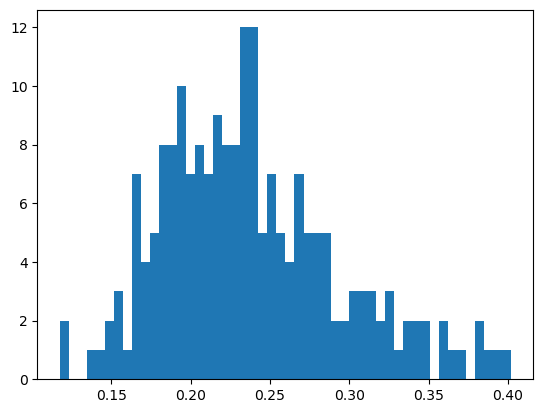

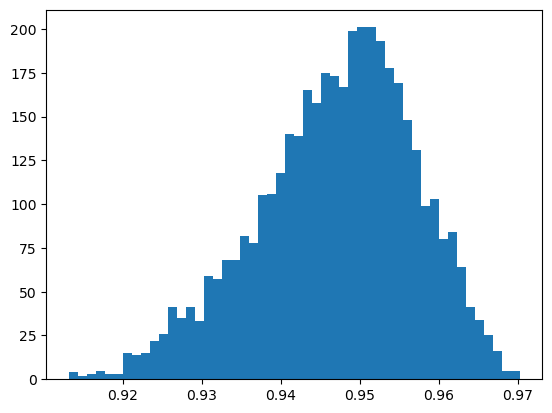

In [30]:
n_samples = 100

y_pred_test, test_samples = model.predict(x_test, n_samples = n_samples)

relative_L2 = np.linalg.norm(y_pred_test - y_test, axis = -1) / np.linalg.norm(y_test, axis = -1)
R2 = [r2_score(y_test[:, i], y_pred_test[:, i]) for i in range(y_test.shape[1])]

print(f'median relative L2: {np.median(relative_L2)}')
print(f'mean relative L2: {np.mean(relative_L2)}')

print(f'median R2: {np.median(R2)}')
print(f'mean R2: {np.mean(R2)}')

plt.hist(relative_L2[relative_L2<2], bins = 50)
plt.show()

plt.hist(R2, bins = 50)
plt.show()

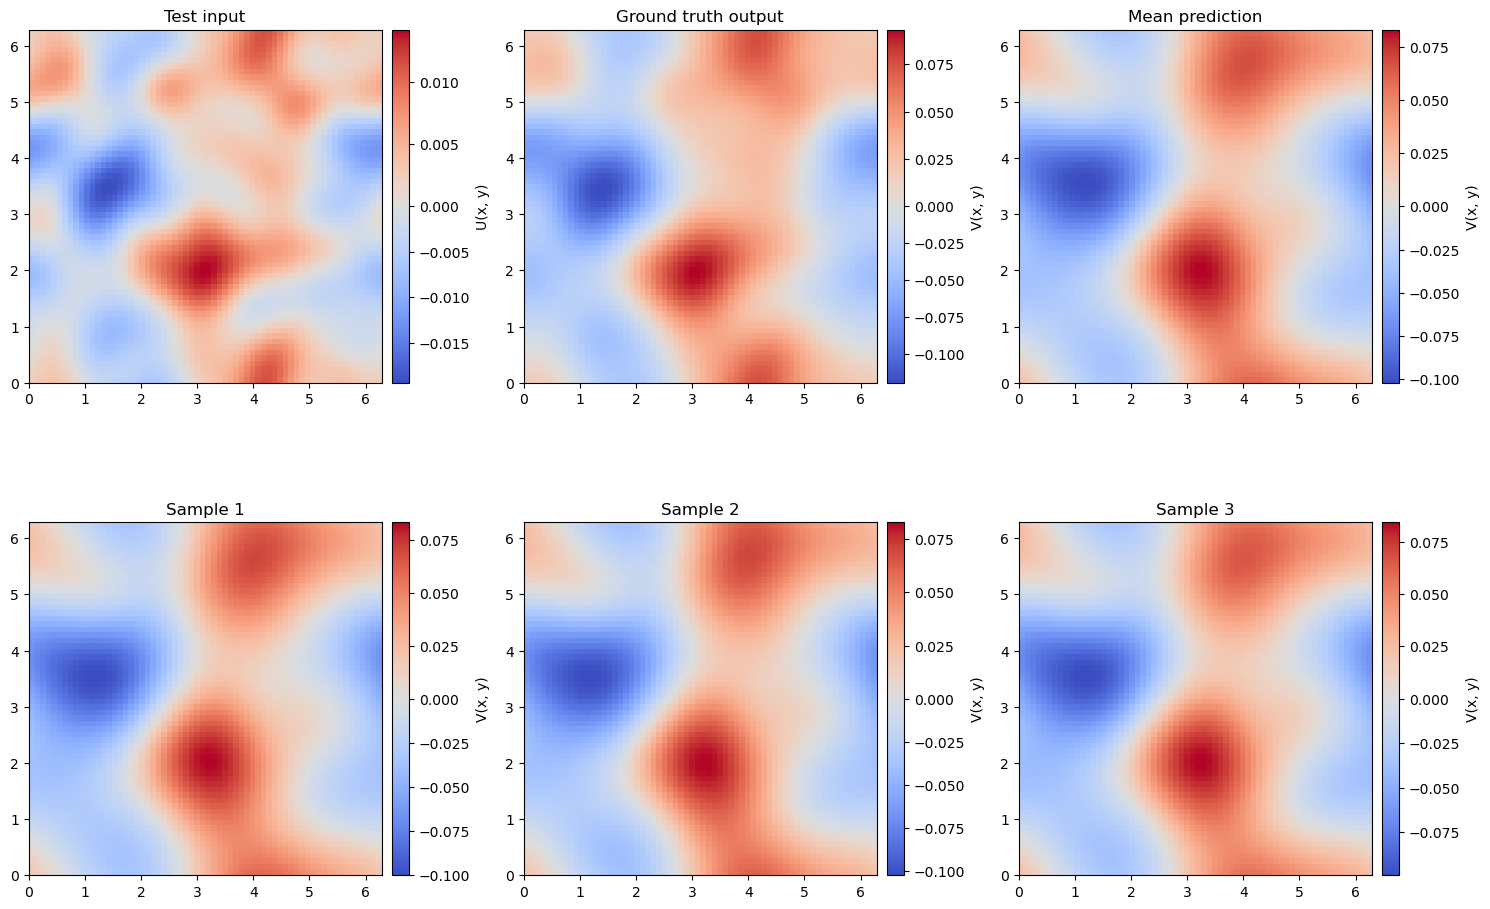

In [31]:
index_to_plot = 127

y_lims = np.array([min(y_test[index_to_plot, :].min(), y_pred_test[index_to_plot, :].min()), max(y_test[index_to_plot, :].max(), y_pred_test[index_to_plot, :].max())])

fig, ax = plt.subplots(2, 3, figsize = (15, 10))
ax = ax.flatten()

im0 = ax[0].imshow(x_test[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, norm = x_norm(), cmap = x_cmap)
ax[0].set_title("Test input")
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(im0, cax=cax, label=r'U(x, y)')

im1 = ax[1].imshow(y_test[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, norm=y_norm(), cmap = y_cmap)
ax[1].set_title("Ground truth output")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(im1, cax=cax, label=r'V(x, y)')

im2 = ax[2].imshow(y_pred_test[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, norm=y_norm(), cmap = y_cmap)
ax[2].set_title("Mean prediction")
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(im2, cax=cax, label=r'V(x, y)')

for i in range(3):
    imi = ax[i+3].imshow(test_samples[index_to_plot, :, i].reshape(s, s), origin='lower', extent=extent, norm=y_norm(), cmap = y_cmap)
    ax[i+3].set_title(f"Sample {i+1}")
    divider = make_axes_locatable(ax[i+3])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(imi, cax=cax, label=r'V(x, y)')
    
            # ax[i].legend()
plt.tight_layout()
# plt.savefig(f"../figures/{problem}_test_result.pdf")
plt.show()

Test at new (lower) resolution

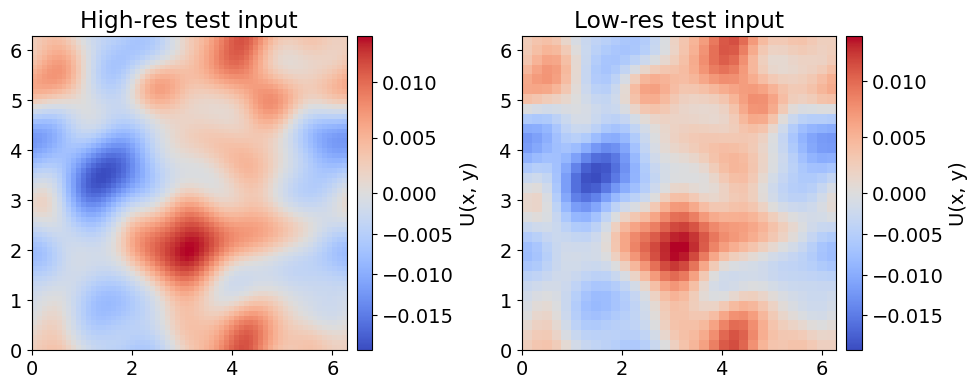

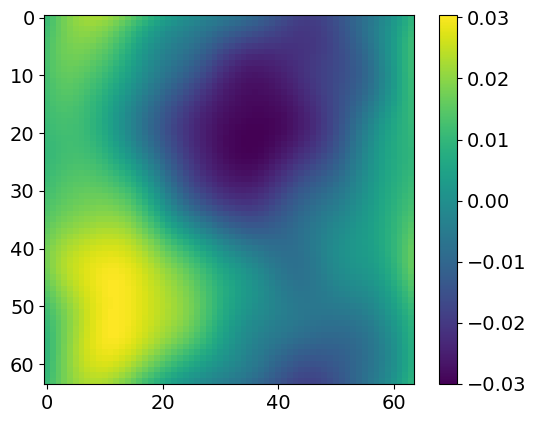

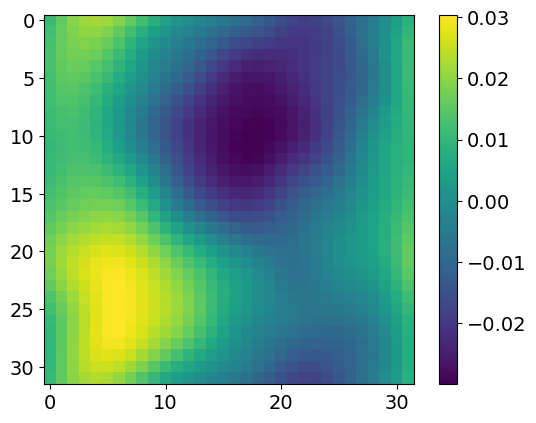

100%|██████████| 20/20 [00:01<00:00, 10.50it/s]


median relative L2: 0.25158564465840627
mean relative L2: 0.260887300730232
median R2: 0.9369190502226209
mean R2: 0.9363652760598032


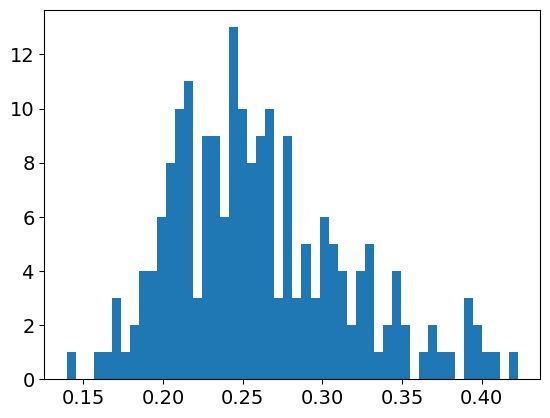

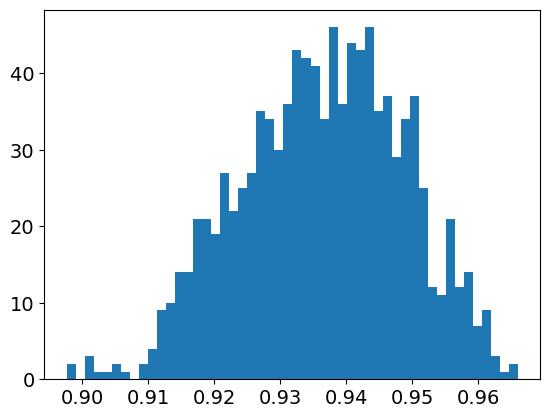

In [70]:
from scipy.ndimage import zoom

new_x_test = zoom(x_test.reshape(-1, s, s), (1, 0.5, 0.5)).reshape(-1, 32 * 32)
new_y_test = zoom(y_test.reshape(-1, s, s), (1, 0.5, 0.5)).reshape(-1, 32 * 32)

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax = ax.flatten()

im0 = ax[0].imshow(x_test[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, norm = x_norm(), cmap = x_cmap)
ax[0].set_title("High-res test input")
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(im0, cax=cax, label=r'U(x, y)')

im1 = ax[1].imshow(new_x_test[index_to_plot, :].reshape(32, 32), origin='lower', extent=extent, norm = x_norm(), cmap = x_cmap)
ax[1].set_title("Low-res test input")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(im1, cax=cax, label=r'U(x, y)')

plt.tight_layout()
plt.show()

new_y_pred_test = model.predict_new_res(new_x_test)

relative_L2 = np.linalg.norm(new_y_pred_test - new_y_test, axis = -1) / np.linalg.norm(new_y_test, axis = -1)
R2 = [r2_score(new_y_test[:, i], new_y_pred_test[:, i]) for i in range(new_y_test.shape[1])]

print(f'median relative L2: {np.median(relative_L2)}')
print(f'mean relative L2: {np.mean(relative_L2)}')

print(f'median R2: {np.median(R2)}')
print(f'mean R2: {np.mean(R2)}')

plt.hist(relative_L2[relative_L2<2], bins = 50)
plt.show()

plt.hist(R2, bins = 50)
plt.show()

(200, 1024)


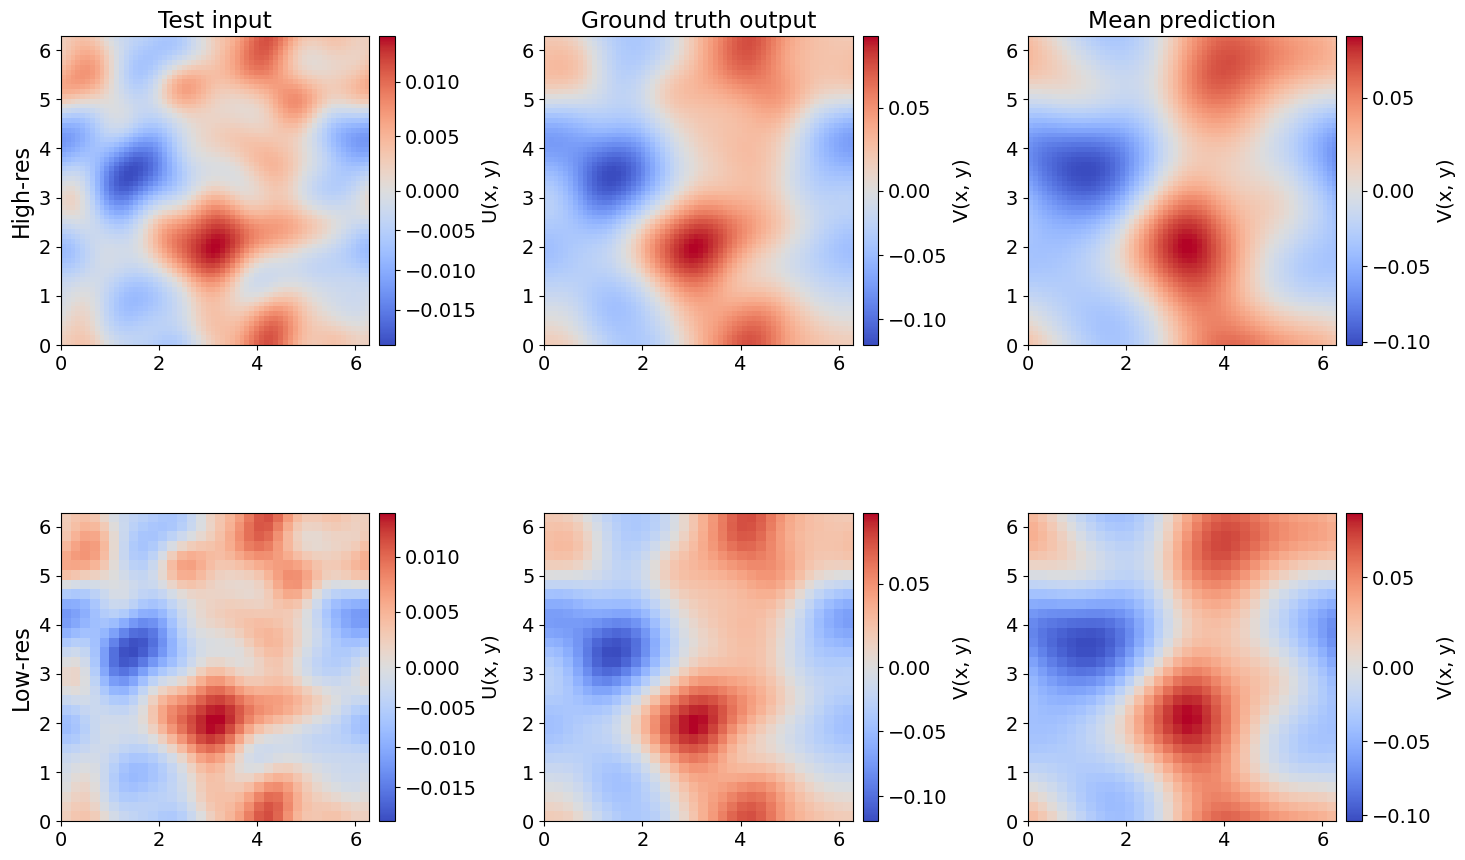

In [71]:
print(new_y_pred_test.shape)

fig, ax = plt.subplots(2, 3, figsize = (15, 10))
ax = ax.flatten()

# high-res

im0 = ax[0].imshow(x_test[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, norm = x_norm(), cmap = x_cmap)
ax[0].set_title("Test input")
ax[0].set_ylabel("High-res", fontsize = 16)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(im0, cax=cax, label=r'U(x, y)')

im1 = ax[1].imshow(y_test[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, norm=y_norm(), cmap = y_cmap)
ax[1].set_title("Ground truth output")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(im1, cax=cax, label=r'V(x, y)')

im2 = ax[2].imshow(y_pred_test[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, norm=y_norm(), cmap = y_cmap)
ax[2].set_title("Mean prediction")
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(im2, cax=cax, label=r'V(x, y)')

# low-res

im3 = ax[3].imshow(new_x_test[index_to_plot, :].reshape(32, 32), origin='lower', extent=extent, norm = x_norm(), cmap = x_cmap)
# ax[3].set_title("Test input")
ax[3].set_ylabel("Low-res", fontsize = 16)
divider = make_axes_locatable(ax[3])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(im3, cax=cax, label=r'U(x, y)')

im4 = ax[4].imshow(new_y_test[index_to_plot, :].reshape(32, 32), origin='lower', extent=extent, norm=y_norm(), cmap = y_cmap)
# ax[4].set_title("Ground truth output")
divider = make_axes_locatable(ax[4])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(im4, cax=cax, label=r'V(x, y)')

im5 = ax[5].imshow(new_y_pred_test[index_to_plot, :].reshape(32, 32), origin='lower', extent=extent, norm=y_norm(), cmap = y_cmap)
# ax[5].set_title("Mean prediction")
divider = make_axes_locatable(ax[5])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(im5, cax=cax, label=r'V(x, y)')

plt.tight_layout()
# plt.savefig(f"../figures/{problem}_mesh_invariant_test_result.pdf")
plt.show()